#Initial Setup

We set up the necessary libraries we need for the assignment

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV


#Preliminary Work

We load the data into a dataframe and explore the data by looking at the first few entries, getting information, and getting descriptive statistics about the data.

In [14]:
# Task 1: Data Loading and Initial Exploration
# Load the Titanic dataset
df = pd.read_excel("./titanic3.xls")
print("Initial Data Preview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Initial Data Preview:
   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0  

#Visualising Missing Values

We use the heatmap to visualize the missing values and get an initial idea of what is going on

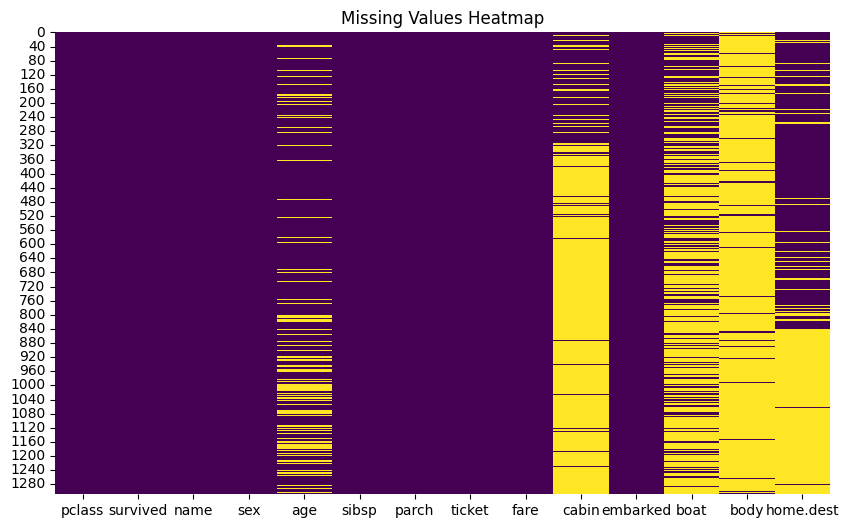

In [15]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

#Dropping Columns

Some of the columns in our data can and should be dropped.
* Name - has little predictive significance unless we extract titles.
* Ticket - quite messy and useless without extracting meaningful symbols.
* Cabin - very high percentage of missing values, might be better to drop for a baseline model.
* Body and Boat - while these could be useful, they are only known post-incident and could introduce leakage, artifically boosting our model's performance.



In [16]:
drop_cols = ['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest']
df.drop(columns=drop_cols, inplace=True)

#Handling Missing Values

To handle the missing values, we input the median for numerical variables and the mode for categorical variables. The median is resistant to outliers, while the mode is the most repeated element, working well for categorical data

In [17]:
missing_cols = df.columns[df.isnull().any()]
for col in missing_cols:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-17-e0b166b3496c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-17-e0b166b3496c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

#Encoding Categorial Values

After we have dropped some of the values, we need to encode the categorical values in our data. We encode them into binary values. To reduce redundancy, we drop the first category, which reduces multicollinearity. This is important for regression-based models.

In [18]:
categorical_features = ['sex', 'embarked', 'pclass']
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = one_hot_encoder.fit_transform(df[categorical_features])
categorical_df = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

df = df.drop(columns=categorical_features).join(categorical_df)

#Feature Scaling

We need to transform the data so that all the numerical features we have contribute equally. To do this, we will standardize the numerical values to have a mean of 0 and a standard deviation of 1. Another option was normalizing the data. For our requirements, I think standardization is preferrable, as it works quite well with regression models

In [19]:
scaler = StandardScaler()
df[['fare', 'sibsp', 'parch']] = scaler.fit_transform(df[['fare', 'sibsp', 'parch']])

#Data Splitting

Data splitting is essential for us. The approach we take is that first the data is split into a 7-3 split, with 70% being the training set, and the 30% being the other set for now. We use stratification on the survived variable to ensure that the proportion is maintained.

The other set is next divided into an equal split of a validation set and a test set. The validation set is used to tune hyperparameters and measure the model's performance. The test set is used to evaluate the model in a non-biased way.

Setting a fixed value for random_state allows.

In [20]:
y = df['survived']
X = df.drop(columns=['survived'])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#Addressing Class Imbalance

The Titanic data is not balanced, because there are more non-survivors than survivors. To deal with this, we apply SMOTE. This balances the training data.

In [21]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Feature Selection

Some of the features should be removed to improve performance by reducing redundancy. These features are supposed to have low variance(contribute little) and high correlation(increases multicollinearity). The feature selection should be done after the data is split to maintain balance among the training, validation and test sets.

In [22]:
constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
if constant_cols:
    print("Dropping constant columns:", constant_cols)
    X_train = X_train.drop(columns=constant_cols)
    X_val = X_val.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)

corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

if len(to_drop) < X_train.shape[1]:
    print("Dropping highly correlated features:", to_drop)
    X_train = X_train.drop(columns=to_drop)
    X_val = X_val.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)
else:
    print("No features dropped from correlation check to avoid empty feature set.")

Dropping highly correlated features: []


In [23]:
print(X_train)

            age     sibsp     parch      fare  sex_male  embarked_Q  \
0     54.000000 -0.479087  0.710763  0.850830   1.00000         0.0   
1     28.000000  0.481288 -0.445000 -0.364003   1.00000         0.0   
2     13.000000  3.362411  1.866526 -0.036611   1.00000         0.0   
3     28.500000 -0.479087 -0.445000 -0.332183   1.00000         0.0   
4     55.500000 -0.479087 -0.445000 -0.487824   1.00000         0.0   
...         ...       ...       ...       ...       ...         ...   
1127  76.493395 -0.479087 -0.445000  0.093486   0.82467         0.0   
1128  30.982839  0.481288 -0.445000  0.458836   1.00000         0.0   
1129  28.000000 -0.251828 -0.171505 -0.467016   1.00000         0.0   
1130  40.000000  0.295852  0.487600  2.027781   0.00000         0.0   
1131  29.000000 -0.479087  1.866526 -0.296780   0.00000         0.0   

      embarked_S  pclass_2  pclass_3  
0       1.000000  0.000000  0.000000  
1       0.000000  0.000000  1.000000  
2       1.000000  0.000000  1.

#Training the Model

We will be using Logistic Regression. This is an efficient model for predicting binary outcomes. After training the model, we make adjustments based on how it performs on the validation set.

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

#Visualising and Testing Results

Here we visualize our results and validate the data, improving model performance if necesary.

In [41]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Test Set Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Test Set Performance:
Accuracy: 0.7817258883248731
Precision: 0.6951219512195121
Recall: 0.76
F1 Score: 0.7261146496815286
ROC AUC: 0.8554644808743168
Confusion Matrix:
 [[97 25]
 [18 57]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       122
           1       0.70      0.76      0.73        75

    accuracy                           0.78       197
   macro avg       0.77      0.78      0.77       197
weighted avg       0.79      0.78      0.78       197



In [40]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both L1 and L2
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Evaluate on validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score: 0.7512128085040702
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       121
           1       0.74      0.79      0.76        75

    accuracy                           0.81       196
   macro avg       0.80      0.81      0.80       196
weighted avg       0.81      0.81      0.81       196



In [37]:
print("Logistic Regression Model Predictions on Validation Set:")
print(y_pred)

Logistic Regression Model Predictions on Validation Set:
[0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0
 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 1 1 0 0 0 1 1 0]
